In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import MultiLineString, Polygon

In [29]:
def assign_park_names_final(original_gpkg_path, osm_gpkg_path, output_path):
    # Load the original geopackage file
    original_parks = gpd.read_file(original_gpkg_path)

    # Create a new column for the park names
    original_parks['Parkname'] = "Unknown Parkname"

    # Load the OSM geopackage file
    osm_parks = gpd.read_file(osm_gpkg_path)

    # Check the current CRS of both datasets and convert them to EPSG:4326 if necessary
    if original_parks.crs != 'epsg:4326':
        original_parks = original_parks.to_crs('epsg:4326')
    if osm_parks.crs != 'epsg:4326':
        osm_parks = osm_parks.to_crs('epsg:4326')

    # Perform a spatial join between the original parks and the OSM parks
    matched_parks = gpd.sjoin(original_parks, osm_parks, how='left', predicate='intersects')

    # Assign the names from the OSM parks to the original parks
    for index, park in matched_parks.iterrows():
        if pd.notnull(park['name']):
            matched_parks.at[index, 'Parkname'] = park['name']

    # Drop all columns except the specified ones
    required_columns = ['geometry', 'bezirk', 'nutzung_bauvor', 'Parkname', 'flalle']
    matched_parks = matched_parks[required_columns]

    # Rename 'flalle' to 'Area' and convert it to integer
    matched_parks = matched_parks.rename(columns={'flalle': 'Area'})
    matched_parks['Area'] = pd.to_numeric(matched_parks['Area'], errors='coerce').fillna(0).astype(int)

    # Separate parks based on Parkname content
    unknown_parks = matched_parks[matched_parks['Parkname'] == 'Unknown Parkname']
    known_parks = matched_parks[matched_parks['Parkname'] != 'Unknown Parkname']

    # Dissolve known parks by 'Parkname', ensuring to retain the 'Parkname'
    agg_funcs = {col: 'first' for col in known_parks.columns if col != 'geometry'}
    dissolved_parks = known_parks.dissolve(by='Parkname', aggfunc=agg_funcs)

    # Concatenate the dissolved known parks with the unknown parks
    final_parks = pd.concat([dissolved_parks, unknown_parks], ignore_index=True)

    # Save the updated geopackage
    final_parks.to_file(output_path, driver='GPKG')

In [31]:
def analyze_park_areas(gpkg_path):
    # Load the geopackage file
    parks = gpd.read_file(gpkg_path)

    # Filter parks by 'Parkname'
    unknown_parks = parks[parks['Parkname'] == 'Unknown Parkname']
    known_parks = parks[parks['Parkname'] != 'Unknown Parkname']

    # Calculate mean and median areas
    mean_unknown = unknown_parks['Area'].mean()
    median_unknown = unknown_parks['Area'].median()
    mean_known = known_parks['Area'].mean()
    median_known = known_parks['Area'].median()

    # Print the statistics
    print("Unknown Parkname - Mean Area: {:.2f}, Median Area: {}".format(mean_unknown, median_unknown))
    print("Known Parkname - Mean Area: {:.2f}, Median Area: {}".format(mean_known, median_known))

    # Plot histograms
    plt.figure(figsize=(12, 6))

    # Histogram for unknown park names
    plt.subplot(1, 2, 1)
    unknown_parks['Area'].hist(bins=30, color='gray', edgecolor='black')
    plt.title('Area Distribution for Unknown Parkname')
    plt.xlabel('Area')
    plt.ylabel('Frequency')

    # Histogram for known park names
    plt.subplot(1, 2, 2)
    known_parks['Area'].hist(bins=30, color='green', edgecolor='black')
    plt.title('Area Distribution for Known Parkname')
    plt.xlabel('Area')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [30]:
assign_park_names_final("data/FN_park_gruenflachen.gpkg", "data/OSM_parks.gpkg", "data/final_FN_park_gruenflachen.gpkg")

Unknown Parkname - Mean Area: 21535.05, Median Area: 11895.5
Known Parkname - Mean Area: 34635.49, Median Area: 15835.0


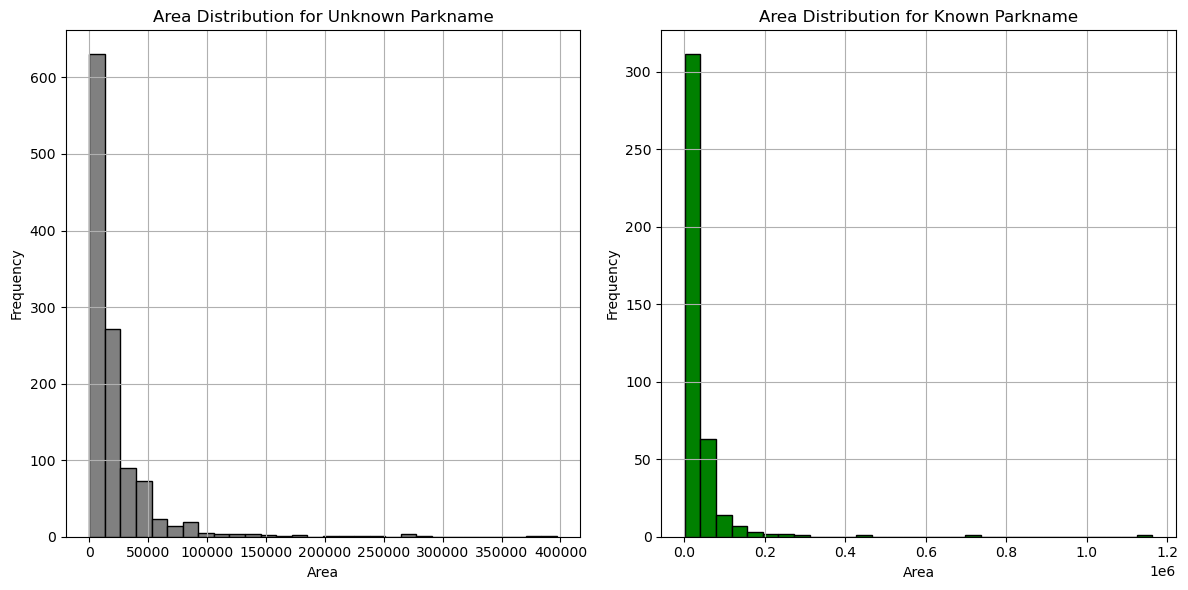

In [34]:
analyze_park_areas("data/final_FN_park_gruenflachen.gpkg")

In [16]:
def assign_berlin_Former_Side(wall_shp_path, bezirke_gpkg_path, output_gpkg_path):
    wall = gpd.read_file(wall_shp_path)
    bezirke = gpd.read_file(bezirke_gpkg_path)
    
    if wall.crs != bezirke.crs:
        wall = wall.to_crs(bezirke.crs)
    
    # Try to fix geometries with a buffer
    wall['geometry'] = wall.geometry.buffer(0.0001).buffer(-0.0001)
    wall['geometry'] = wall.geometry.simplify(tolerance=0.001, preserve_topology=True)
    
    try:
        wall_union = wall.geometry.unary_union
    except Exception as e:
        print(f"Error during unary_union, trying individual unions: {e}")
        # If unary union fails, try to merge polygons one by one
        wall_union = wall.geometry.iloc[0]
        for geom in wall.geometry[1:]:
            wall_union = wall_union.union(geom)

    wall_bbox = wall_union.envelope  # This creates a bounding box
    bezirke['Former_Side'] = 'Former East Berlin'

    for index, bezirk in bezirke.iterrows():
        if bezirk.geometry.within(wall_bbox):
            bezirke.at[index, 'Former_Side'] = 'Former West Berlin'


    bezirke.to_file(output_gpkg_path, driver='GPKG')

In [21]:
def create_west_berlin(ortsteile_gpkg_path, output_gpkg_path):
    ortsteile = gpd.read_file(ortsteile_gpkg_path)

    west_berlin = ortsteile[ortsteile['Former_Side'] == 'Former West Berlin']
    west_berlin = west_berlin.dissolve(by='Former_Side')

    west_berlin.to_file(output_gpkg_path, driver='GPKG')
    
# Example usage
create_west_berlin("data/boundary_ortsteile.gpkg", "data/west_berlin.gpkg")
